In [184]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py


os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID')
name = 'simulated_outputs_testing.csv'
data = pd.read_csv(name)

t = data.iloc[1:, 0].values
Vp = data.iloc[1:, 1].values
Vy = data.iloc[1:, 2].values
pitch = data.iloc[1:, 3].values
yaw = data.iloc[1:, 4].values

# Compute velocity derivatives
tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity= np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

# Compute acceleration derivatives
# We are computing accelerations becuase we don't trust the measured values are labeled correctly
d2pitchdt2 = np.array([np.diff(pitch_velocity, n=1)])
d2pitchdt2 = np.transpose(d2pitchdt2)/tstep
d2pitchdt2= np.append(d2pitchdt2, 0)
d2yawdt2 = np.array([np.diff(yaw_velocity, n=1)])
d2yawdt2 = np.transpose(d2yawdt2)/tstep
d2yawdt2 = np.append(d2yawdt2, 0)

inputs = np.array([t, Vp, Vy, pitch, yaw, pitch_velocity, yaw_velocity, d2yawdt2]) # Everything in the order previously defined
inputs = np.transpose(inputs)

output_test= np.array([d2pitchdt2])
output_test = np.transpose(output_test)


def nrmse(actual_values, predicted_values):
    """
    Calculate Normalized Root Mean Squared Error (NRMSE) for regression. Normalized over the range of the target variable
    In this case it's the range of the pitch acceleration data

    Parameters:
    - actual_values: NumPy array or list of actual values.
    - predicted_values: NumPy array or list of predicted values.

    Returns:
    - nrmse: Normalized Root Mean Squared Error.
    """
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    if len(actual_values) != len(predicted_values):
        raise ValueError("Length of actual_values and predicted_values must be the same.")

    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

    # Calculate the range of the target variable
    target_range = np.max(actual_values) - np.min(actual_values)

    # Calculate NRMSE
    nrmse = (rmse / target_range) * 100 # Expressed as a percentage

    return nrmse

def percent_error(actual, predicted):
    error = 100 * abs(actual - predicted) / abs(actual)
    return error



# Load the model from the HDF5 file
os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID/hyper_parameter_study_models')
folder_path = '/home/coder/workspace/VanderWiel/Fennec2023/SystemID/hyper_parameter_study_models'
file_names = os.listdir(folder_path)



avg_errors, nrmses, coeffs, learning_rates, epochs = [], [], [], [], []
for i, file_name in enumerate(file_names):
    
    loaded_model = tf.keras.models.load_model(file_name)
    pitch_predictions_fnn = loaded_model.predict(inputs)

    # Metrics
    nrmse_value = nrmse(output_test,pitch_predictions_fnn[:,0])
    rounded_nrmse = round(nrmse_value, 3)
    nrmse_text = f'Normalized RMSE for accelerations: {rounded_nrmse}%'
    nrmses.append(nrmse_value)

    predict_coeff1 = np.mean(pitch_predictions_fnn[:,1])
    predict_coeff2 = np.mean(pitch_predictions_fnn[:,2])
    predict_coeff3 = np.mean(pitch_predictions_fnn[:,3])
    predict_coeff4 = np.mean(pitch_predictions_fnn[:,4])
    coeffs.append([predict_coeff1,predict_coeff2,predict_coeff3,predict_coeff4])

    error1 = percent_error(-0.321,predict_coeff1)
    error2 = percent_error(-0.086,predict_coeff2)
    error3 = percent_error(0.023,predict_coeff3)
    error4 = percent_error(0.0099,predict_coeff4)
    avg_error = (error1+error2+error3+error4)/4
    avg_errors.append(avg_error)


    # Open the HDF5 file for reading
    with h5py.File(file_name, 'r') as f:
        # Check if the 'learning_rate' attribute exists
        if 'learning_rate' in f.attrs:
            # Retrieve the learning rate
            learning_rate = f.attrs['learning_rate']
            learning_rates.append(learning_rate)
        else:
            print('**WARNING: Learning Rate not saved for this file!**')
        
        # Check if the 'epochs' attribute exists
        if 'epochs' in f.attrs:
            # Retrieve the number of epochs
            epoch = f.attrs['epochs']
            epochs.append(epoch)
        else:
            print('**WARNING: Number of epochs not saved for this file!**')

    print(i)



   1/1563 [..............................] - ETA: 58s

1563/1563 [==============================] - 2s 1ms/step
**WARNING: Number of epochs not saved for this file!**
0
1563/1563 [==============================] - 2s 1ms/step
1
1563/1563 [==============================] - 1s 929us/step
2
1563/1563 [==============================] - 2s 1ms/step
3
1563/1563 [==============================] - 2s 1ms/step
4
1563/1563 [==============================] - 2s 1ms/step
5
1563/1563 [==============================] - 1s 914us/step
6
1563/1563 [==============================] - 2s 1ms/step
7
1563/1563 [==============================] - 2s 1ms/step
8
1563/1563 [==============================] - 2s 1ms/step
9
1563/1563 [==============================] - 2s 1ms/step
10
1563/1563 [==============================] - 2s 1ms/step
11
1563/1563 [==============================] - 2s 1ms/step
12
1563/1563 [==============================] - 2s 971us/step
13
1563/1563 [==============================] - 2s 996us/step
14
1563/1563 [==============================] - 2s

In [1]:
min_number = min(avg_errors)
min_index = avg_errors.index(min_number)

# print(min_index)
# print(coeffs)

print(min_index)
print(coeffs[min_index])
print(avg_errors[min_index])
print(nrmses[min_index])
print('learning_rate:', learning_rates[min_index])
print('epochs:', epochs[min_index])

# learnrate_8_epoch_7.h5
print(file_names[min_index])

NameError: name 'avg_errors' is not defined

### Best file from the parameter study

In [3]:
os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID/hyper_parameter_study_models')
best_model = file_names[min_index]

loaded_model = tf.keras.models.load_model(best_model)

pitch_predictions_fnn = loaded_model.predict(inputs)

NameError: name 'file_names' is not defined

In [12]:
import os
import h5py

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID/hyper_parameter_study_models')

# Open the HDF5 file for reading
with h5py.File('learnrate_8_epoch_7.h5', 'r') as f:
    # Retrieve the learning rate
    learning_rate = f.attrs['learning_rate']
    print(learning_rate)
    epochs = f.attrs['epochs']
    print(epochs)


0.03593813663804626
4000


[ 0.04258727  0.04966806  0.07739956 ... -0.01399969 -0.006067
  0.00667771]


NameError: name 'nrmse' is not defined

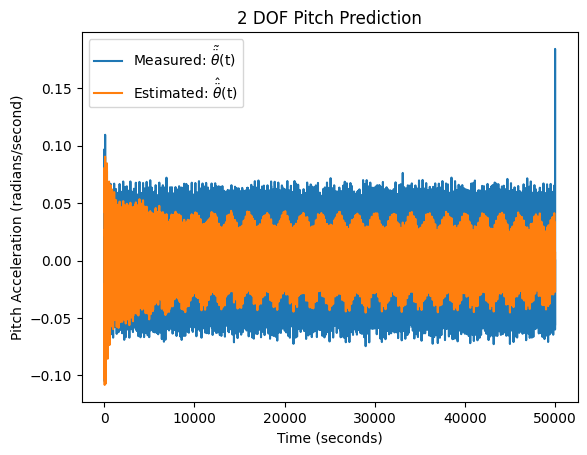

In [11]:
# Plotting 
plt.figure()
# t = input_test[:,0]
plt.plot(output_test)
plt.plot(pitch_predictions_fnn[:,0])
plt.legend([r'Measured: $\tilde{\ddot{\theta}}$(t)', r'Estimated: $\hat{\ddot{\theta}}$(t)'])
plt.ylabel('Pitch Acceleration (radians/second)')
plt.xlabel('Time (seconds)')
plt.title('2 DOF Pitch Prediction')
print(pitch_predictions_fnn[:,0])
# plt.xlim([0,200])
# plt.ylim([-0.06,0])

nrmse_value = nrmse(output_test,pitch_predictions_fnn[:,0])
rounded_nrmse = round(nrmse_value, 3)
nrmse_text = f'Normalized RMSE: {rounded_nrmse}%'
# Add a textbox with the NRMSE value
plt.annotate(nrmse_text, xy=(0.05, 0.92), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.7))


plt.figure()
predict_coeff1 = pitch_predictions_fnn[:,1]
plt.plot(predict_coeff1)
plt.plot([0,len(output_test)], [-0.321,-0.321])
plt.xlabel('time step')
plt.title('Coeff 1')
print(np.mean(predict_coeff1), -0.321)

plt.figure()
predict_coeff2 = pitch_predictions_fnn[:,2]
plt.plot(predict_coeff2)
plt.plot([0,len(output_test)], [-0.086, -0.086])
print(np.mean(predict_coeff2), -0.086)

plt.figure()
predict_coeff3 = pitch_predictions_fnn[:,3]
plt.plot(predict_coeff3)
plt.plot([0,len(output_test)], [0.023, 0.023])
print(np.mean(predict_coeff3), 0.023)

plt.figure()
predict_coeff4 = pitch_predictions_fnn[:,4]
plt.plot(predict_coeff4)
plt.plot([0,len(output_test)], [0.0099, 0.0099])
print(np.mean(predict_coeff4), 0.0099)

The below results seem strange. It makes it appear that the model is relatively robust to hyperparameters. I think I need to try initializing the weights to the same value on each training attempt to get rid of any possible variation that might cause

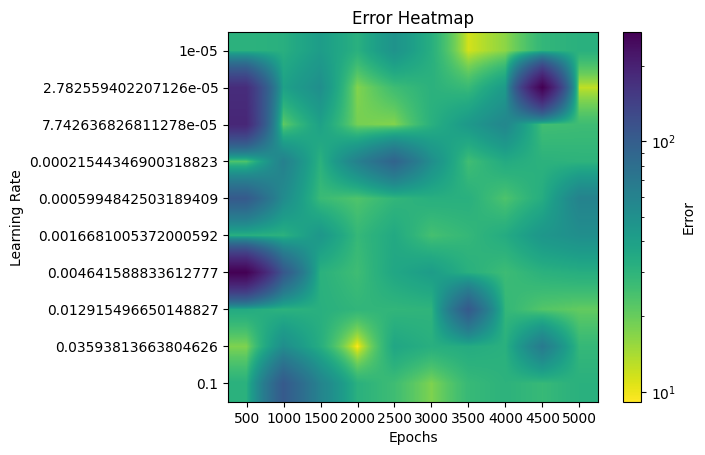

In [218]:
import matplotlib.colors as colors

avg_errors = np.array(avg_errors)
learning_rates = np.array(learning_rates)
epochs = np.array(epochs)

# print(len(epochs))
# print(np.unique(learning_rates))

# Reshape errors to create a 2D array
error_matrix = avg_errors.reshape(len(np.unique(learning_rates)), len(np.unique(epochs)))

# Create a heatmap
plt.imshow(error_matrix, cmap='viridis_r', norm=colors.LogNorm(vmin=error_matrix.min(), vmax=error_matrix.max()), interpolation='bilinear')
# plt.imshow(error_matrix, cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Error')
plt.xticks(np.arange(len(np.unique(epochs))), np.unique(epochs))
plt.yticks(np.arange(len(np.unique(learning_rates))), np.unique(learning_rates))
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Error Heatmap')
plt.show()